# Training a model using Pytorch
Source:  
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html


## Import things

In [18]:
import os
import cv2
import numpy as np
import pandas as pd
import random

import tifffile as tiff
from PIL import Image, ImageDraw
from torchvision.transforms import ToPILImage  
import matplotlib.pyplot as plt

import pycocotools

import torch
import torchvision
import torch.utils.data

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import utils
import transforms as T
from engine import train_one_epoch, evaluate

In [19]:
image_path = '../train/images/slices/'
images = os.listdir(image_path)

data_path = '../CSVs'
datafiles = os.listdir(data_path)

### Some functions

In [20]:
# this function turns the dataframe of coordinates into arrays

def parse_one_annot(path_to_data_file, filename):
    data = pd.read_csv(path_to_data_file)
    boxes_array = data[data["filename"] == filename][["xmin", "ymin",        
    "xmax", "ymax"]].values
   
    return boxes_array

In [22]:
## This model will give you bounding boxes and masks

def get_model(num_classes):
   # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
   # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
   
    return model

In [23]:
# This function converts an image into a PyTorch Tensor
# and flips the image horizontally sometimes during training

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
      # during training, randomly flip the training images
      # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### Make a Glomeruli class 

In [24]:
class GlomeruliDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'train/images/slices')))
        self.path_to_data_file = data_file
        self.masks = sorted(os.listdir(os.path.join(root, 'train/masks/slices')))
        
    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root,'train/images/slices', self.imgs[idx])

        img = tiff.imread(img_path)
        if len(img.shape) == 5:
            img = img.squeeze().transpose(1, 2, 0)
                    
        
        #boxes
        box_list = parse_one_annot(self.path_to_data_file, self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    
    def __len__(self):
        return len(self.imgs)

In [25]:
# Try out the class and see what it gives you:
dataset = GlomeruliDataset(root = '..', 
                           data_file = '../CSVs/glomeruli_tiles.csv')
dataset.__getitem__(111)

(array([[194, 112, 152, ..., 180, 187, 161],
        [220, 137, 127, ...,  78, 132, 210],
        [209, 152, 116, ...,  87, 104, 165],
        ...,
        [127, 141, 171, ..., 201, 202, 136],
        [167, 169, 171, ..., 201, 201, 219],
        [157, 123, 103, ..., 197, 206, 217]], dtype=uint8),
 {'boxes': tensor([[  0., 191.,  88., 347.],
          [  0.,  38.,  84., 104.]]),
  'labels': tensor([1, 1]),
  'image_id': tensor([111]),
  'area': tensor([13728.,  5544.]),
  'iscrowd': tensor([0, 0])})

### Setting up datasets

In [26]:
# use our dataset and defined transformations
dataset = GlomeruliDataset(root = '..',
                           data_file = '../CSVs/glomeruli_tiles.csv', 
                           transforms = get_transform(train=True))

dataset_test = GlomeruliDataset(root = '..', 
                                data_file = '../CSVs/glomeruli_tiles.csv',
                                transforms = get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-200])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-200:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=1, shuffle=False, num_workers=0,
              collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=0,
         collate_fn=utils.collate_fn)

print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 1797 examples, 1597 are training and 200 testing


In [27]:
torch.cuda.is_available()

True

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# our dataset has two classes only - glomeruli and not glomeruli
num_classes = 2

# get the model using our helper function
model = get_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001,
                            momentum=0.9, weight_decay=0.001)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [29]:
num_epochs = 1

for epoch in range(num_epochs):  
   # train for one epochs, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch,
                   print_freq=10)
    # update the learning rate
    lr_scheduler.step()

Epoch: [0]  [   0/1597]  eta: 0:11:48  lr: 0.000000  loss: 1.1905 (1.1905)  loss_classifier: 0.7191 (0.7191)  loss_box_reg: 0.0247 (0.0247)  loss_objectness: 0.4266 (0.4266)  loss_rpn_box_reg: 0.0201 (0.0201)  time: 0.4436  data: 0.0140  max mem: 3840
Epoch: [0]  [  10/1597]  eta: 0:13:39  lr: 0.000001  loss: 1.0955 (1.4417)  loss_classifier: 0.7191 (0.7418)  loss_box_reg: 0.0949 (0.1325)  loss_objectness: 0.1819 (0.5297)  loss_rpn_box_reg: 0.0170 (0.0378)  time: 0.5163  data: 0.0126  max mem: 4254
Epoch: [0]  [  20/1597]  eta: 0:12:46  lr: 0.000002  loss: 0.9859 (1.2517)  loss_classifier: 0.7260 (0.7426)  loss_box_reg: 0.1479 (0.1528)  loss_objectness: 0.0644 (0.3324)  loss_rpn_box_reg: 0.0082 (0.0239)  time: 0.4885  data: 0.0136  max mem: 4254
Epoch: [0]  [  30/1597]  eta: 0:12:07  lr: 0.000003  loss: 0.8993 (1.1965)  loss_classifier: 0.7256 (0.7307)  loss_box_reg: 0.1376 (0.1532)  loss_objectness: 0.0474 (0.2926)  loss_rpn_box_reg: 0.0051 (0.0201)  time: 0.4356  data: 0.0139  max me

Epoch: [0]  [ 330/1597]  eta: 0:09:48  lr: 0.000033  loss: 0.2640 (0.6129)  loss_classifier: 0.1281 (0.2719)  loss_box_reg: 0.1042 (0.1344)  loss_objectness: 0.0423 (0.1832)  loss_rpn_box_reg: 0.0039 (0.0234)  time: 0.4565  data: 0.0134  max mem: 4254
Epoch: [0]  [ 340/1597]  eta: 0:09:44  lr: 0.000034  loss: 0.2535 (0.6055)  loss_classifier: 0.1139 (0.2675)  loss_box_reg: 0.1199 (0.1341)  loss_objectness: 0.0327 (0.1809)  loss_rpn_box_reg: 0.0043 (0.0230)  time: 0.4711  data: 0.0122  max mem: 4254
Epoch: [0]  [ 350/1597]  eta: 0:09:39  lr: 0.000035  loss: 0.3513 (0.6010)  loss_classifier: 0.1116 (0.2647)  loss_box_reg: 0.1185 (0.1354)  loss_objectness: 0.0224 (0.1782)  loss_rpn_box_reg: 0.0037 (0.0227)  time: 0.4677  data: 0.0136  max mem: 4254
Epoch: [0]  [ 360/1597]  eta: 0:09:34  lr: 0.000036  loss: 0.4346 (0.5954)  loss_classifier: 0.1372 (0.2616)  loss_box_reg: 0.1161 (0.1361)  loss_objectness: 0.0237 (0.1753)  loss_rpn_box_reg: 0.0054 (0.0224)  time: 0.4628  data: 0.0188  max me

Epoch: [0]  [ 660/1597]  eta: 0:07:17  lr: 0.000066  loss: 0.2290 (0.4916)  loss_classifier: 0.0759 (0.1962)  loss_box_reg: 0.0973 (0.1383)  loss_objectness: 0.0271 (0.1334)  loss_rpn_box_reg: 0.0048 (0.0238)  time: 0.4771  data: 0.0213  max mem: 4254
Epoch: [0]  [ 670/1597]  eta: 0:07:12  lr: 0.000067  loss: 0.2310 (0.4887)  loss_classifier: 0.0849 (0.1948)  loss_box_reg: 0.1291 (0.1386)  loss_objectness: 0.0265 (0.1318)  loss_rpn_box_reg: 0.0046 (0.0235)  time: 0.4631  data: 0.0205  max mem: 4254
Epoch: [0]  [ 680/1597]  eta: 0:07:07  lr: 0.000068  loss: 0.2692 (0.4865)  loss_classifier: 0.0951 (0.1936)  loss_box_reg: 0.1546 (0.1393)  loss_objectness: 0.0241 (0.1303)  loss_rpn_box_reg: 0.0036 (0.0233)  time: 0.4593  data: 0.0168  max mem: 4254
Epoch: [0]  [ 690/1597]  eta: 0:07:03  lr: 0.000069  loss: 0.2740 (0.4843)  loss_classifier: 0.0890 (0.1923)  loss_box_reg: 0.1381 (0.1396)  loss_objectness: 0.0241 (0.1292)  loss_rpn_box_reg: 0.0039 (0.0231)  time: 0.4695  data: 0.0174  max me

Epoch: [0]  [ 990/1597]  eta: 0:04:44  lr: 0.000099  loss: 0.1788 (0.4251)  loss_classifier: 0.0607 (0.1611)  loss_box_reg: 0.1117 (0.1409)  loss_objectness: 0.0081 (0.1011)  loss_rpn_box_reg: 0.0026 (0.0220)  time: 0.4914  data: 0.0215  max mem: 4254
Epoch: [0]  [1000/1597]  eta: 0:04:39  lr: 0.000100  loss: 0.1960 (0.4230)  loss_classifier: 0.0567 (0.1602)  loss_box_reg: 0.1176 (0.1407)  loss_objectness: 0.0091 (0.1003)  loss_rpn_box_reg: 0.0042 (0.0218)  time: 0.4806  data: 0.0241  max mem: 4254
Epoch: [0]  [1010/1597]  eta: 0:04:34  lr: 0.000100  loss: 0.2014 (0.4211)  loss_classifier: 0.0567 (0.1593)  loss_box_reg: 0.1303 (0.1408)  loss_objectness: 0.0091 (0.0994)  loss_rpn_box_reg: 0.0026 (0.0217)  time: 0.4661  data: 0.0195  max mem: 4254
Epoch: [0]  [1020/1597]  eta: 0:04:29  lr: 0.000100  loss: 0.1927 (0.4191)  loss_classifier: 0.0561 (0.1585)  loss_box_reg: 0.1303 (0.1407)  loss_objectness: 0.0062 (0.0985)  loss_rpn_box_reg: 0.0023 (0.0215)  time: 0.4516  data: 0.0152  max me

Epoch: [0]  [1320/1597]  eta: 0:02:09  lr: 0.000100  loss: 0.1938 (0.3870)  loss_classifier: 0.0548 (0.1413)  loss_box_reg: 0.0882 (0.1378)  loss_objectness: 0.0293 (0.0860)  loss_rpn_box_reg: 0.0063 (0.0218)  time: 0.4544  data: 0.0149  max mem: 4254
Epoch: [0]  [1330/1597]  eta: 0:02:04  lr: 0.000100  loss: 0.1894 (0.3857)  loss_classifier: 0.0531 (0.1408)  loss_box_reg: 0.0758 (0.1377)  loss_objectness: 0.0136 (0.0855)  loss_rpn_box_reg: 0.0060 (0.0217)  time: 0.4602  data: 0.0153  max mem: 4254
Epoch: [0]  [1340/1597]  eta: 0:02:00  lr: 0.000100  loss: 0.1949 (0.3844)  loss_classifier: 0.0549 (0.1403)  loss_box_reg: 0.0984 (0.1375)  loss_objectness: 0.0101 (0.0849)  loss_rpn_box_reg: 0.0042 (0.0216)  time: 0.4577  data: 0.0152  max mem: 4254
Epoch: [0]  [1350/1597]  eta: 0:01:55  lr: 0.000100  loss: 0.1482 (0.3827)  loss_classifier: 0.0528 (0.1396)  loss_box_reg: 0.0889 (0.1372)  loss_objectness: 0.0065 (0.0843)  loss_rpn_box_reg: 0.0016 (0.0215)  time: 0.4448  data: 0.0153  max me

### Need to save the model

In [30]:
# make a folder for the model to live in
try:
    os.mkdir("../model")
except FileExistsError:
    pass

In [31]:
# save the model
torch.save(model.state_dict(), "../model/glomeruli_segmentation_model")

### Visualize the predictions

In [33]:
# load the model that we just made
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("../model/glomeruli_segmentation_model"))

<All keys matched successfully>

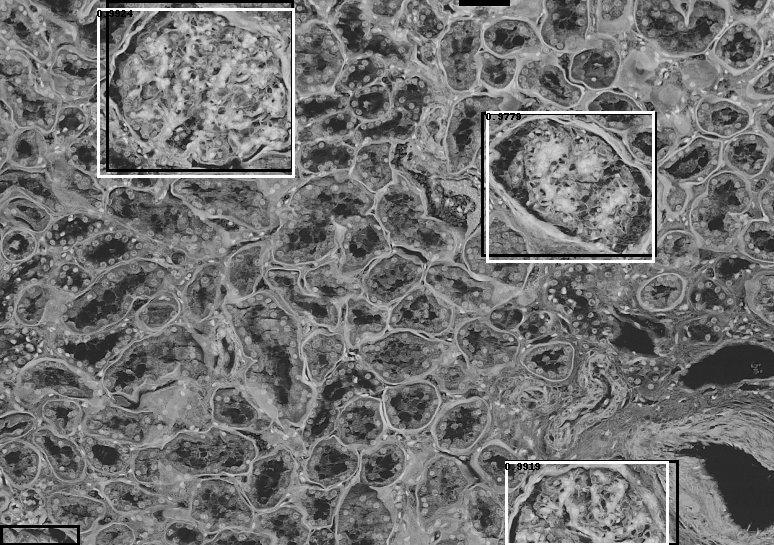

In [34]:
idx = 1
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])

# put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
    prediction = loaded_model([img])

# turn the test images from tensor arrays to PIL image
x = img*255
image = ToPILImage()(x) 

# draw the boxes around the predicted glomeruli, return the image
draw = ImageDraw.Draw(image)
for elem in range(len(label_boxes)):
    draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
    (label_boxes[elem][2], label_boxes[elem][3])], 
    outline ="black", width =3)

for element in range(len(prediction[0]["boxes"])):
    boxes = prediction[0]["boxes"][element].cpu().numpy()
    score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
    
    if score > 0.80:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
                        outline ='white', width =3)
        draw.text((boxes[0], boxes[1]), text = str(score))
                
image

### Make a test class

In [35]:
class TestingDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'test/images/slices')))
    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root,'test/images/slices', self.imgs[idx])
        img = tiff.imread(img_path)
        if len(img.shape) == 5:
            img = img.squeeze().transpose(1, 2, 0)
        
        # there is only one class
        image_id = torch.tensor([idx])
        imgid = self.imgs[idx]
        target = {}
        if self.transforms is not None:
            img = self.transforms(img, target)
        return img, imgid
    def __len__(self):
        return len(self.imgs)

In [36]:
testset = TestingDataset(root = '..', 
                         transforms = get_transform(train=False))
testset.__getitem__(0)

IndexError: list index out of range

### Use model on Test images

In [ ]:
loaded_model = get_model_instance_segmentation(num_classes = 2)
loaded_model.load_state_dict(torch.load("../model/glomeruli_segmentation_model"))

In [ ]:
%%time
if torch.cuda.is_available():
    loaded_model.cuda()

loaded_model.eval()

predictions = []
for i in range(len(testset)):
    predict = {}
    tensor_img = testset[i][0][0][None, :,:].to(device)
    
    with torch.no_grad():
        preds = loaded_model(tensor_img)
        predictions.append(preds)

### Turn predictions into a dataframe and save as a csv

In [ ]:
prediction =[]

In [ ]:
predictions[0][0]

In [ ]:
for x in range(len(predictions)):
    prediction.append(predictions[x][0])

In [ ]:
prediction

In [ ]:
test_preds = pd.DataFrame(prediction)

In [ ]:
test_preds['filename'] = testset.imgs

In [ ]:
test_preds = test_preds[['filename', 'boxes', 'scores', 'labels']]

In [ ]:
test_preds.to_csv('../CSVs/test_preds.csv', index=False)

### Visualize predictions

In [ ]:
idx = 2635

img, _ = testset[idx][0]

# turn the test images from tensor arrays to PIL image
x = img*255
image = ToPILImage()(x) 

# draw the boxes around the predicted glomeruli, return the image
draw = ImageDraw.Draw(image)

for ele in range(len(test_preds.loc[idx]['boxes'])):
    boxes = prediction[idx]['boxes'][ele].cpu().numpy()
    score = np.round(prediction[idx]["scores"][ele].cpu().numpy(),
                    decimals= 4)
    if score > 0.91:
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
        outline ='white', width =3)
        draw.text((boxes[0], boxes[1]), text = str(score))
image